In [16]:
!pip install torch_geometric

In [17]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.neighbors import kneighbors_graph
import numpy as np
from torch_geometric.data import Data
from scipy.sparse import coo_matrix
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges
from sklearn.manifold import TSNE
import tracemalloc
import time
from utils import *
from metrics import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to measure GPU memory usage
def get_gpu_memory():
    return torch.cuda.memory_allocated() / (1024 * 1024)  # Convert to MB

# Load the Fashion-MNIST dataset
def load_fmnist():
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.FashionMNIST(root='.', train=True, transform=transform, download=True)
    return train_dataset

# Convert images to feature vectors
def preprocess_data(dataset):
    data = dataset.data.numpy()
    num_samples = data.shape[0]
    data = data.reshape(num_samples, -1) / 255.0
    labels = dataset.targets.numpy()
    return data, labels

def create_knn_graph_with_random_neighbor(data, k):
    # Measure start time
    start_time = time.time()

    # Start memory tracking
    tracemalloc.start()
    initial_gpu_memory = get_gpu_memory()

    knn_graph = kneighbors_graph(data, k, mode='connectivity', include_self=False)
    coo = coo_matrix(knn_graph)
    row = coo.row.tolist()
    col = coo.col.tolist()

    # Add one random neighbor for each node
    num_samples = data.shape[0]
    for i in range(num_samples):
        random_neighbor = random.choice(range(num_samples))
        row.append(i)
        col.append(random_neighbor)

    new_knn_graph = coo_matrix((np.ones(len(row)), (row, col)), shape=(num_samples, num_samples))

    # Measure end time
    end_time = time.time()

    # Measure memory usage
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    final_gpu_memory = get_gpu_memory()

    # Calculate and print metrics
    time_taken = end_time - start_time
    ram_used = (current - peak) / 1024 / 1024  # Convert to MB
    gpu_used = final_gpu_memory - initial_gpu_memory

    print(f"Time taken to build KNN graph: {time_taken:.2f} seconds")
    print(f"RAM used to build KNN graph: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
    print(f"GPU memory used to build KNN graph: {gpu_used:.2f}MB")

    return new_knn_graph

# Convert the sparse matrix to edge_index format for PyTorch Geometric
def convert_to_torch_geometric_graph(knn_graph):
    coo = coo_matrix(knn_graph)
    edge_index = torch.tensor(np.vstack((coo.row, coo.col)), dtype=torch.long)
    return edge_index

# Main function to execute the steps
def get_fmnist_graph(n_samples=35000):
    # Load and preprocess the data
    train_dataset = load_fmnist()
    x_train, y_train = preprocess_data(train_dataset)

    # Use a subset of the data for simplicity (e.g., first 1000 samples)
    x_subset = x_train[:n_samples]
    y_subset = y_train[:n_samples]

    # Create KNN graph
    k = 4  # Number of neighbors
    knn_graph = create_knn_graph_with_random_neighbor(x_subset, k)

    # Convert to PyTorch Geometric Data object
    edge_index = convert_to_torch_geometric_graph(knn_graph)
    x = torch.tensor(x_subset, dtype=torch.float)
    y = torch.tensor(y_subset, dtype=torch.long)
    data = Data(x=x, edge_index=edge_index, y=y)

    # Set additional attributes for compatibility
    data.num_node_features = data.x.shape[1]
    data.num_classes = len(torch.unique(data.y))
    data.num_features = data.num_node_features

    # Print the Data object to verify
    print(data)
    print(f"Number of node features: {data.num_node_features}")
    print(f"Number of classes: {data.num_classes}")
    print(f"Number of features: {data.num_features}")

    generate_train_test(data)

    return data

In [18]:
data = get_fmnist_graph(25000)

X = data.x.numpy()

local_metrics = LocalMetric()

Time taken to build KNN graph: 45.27 seconds
RAM used to build KNN graph: Current=13.26MB, Peak=13.26MB
GPU memory used to build KNN graph: 0.00MB
Data(x=[25000, 784], edge_index=[2, 125000], y=[25000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [19]:
# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
# data.train_mask = data.val_mask = data.test_mask = data.y = None  # Ensure these are not used by train_test_split_edges
data = train_test_split_edges(data)

class ResidualGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ResidualGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        # Residual connection from input to output
        self.shortcut = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        identity = x

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))

        if x.size(-1) != identity.size(-1):
            identity = self.shortcut(identity)

        x = self.conv3(x, edge_index)

        x += identity  # Add the input to the output
        return x


class GNNNodeClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNNodeClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Parameters
out_channels_AE = 2
num_features = data.num_features
num_classes = data.num_classes
epochs_AE = 200
hidden_channels_AE = 16

# Model initialization
model = GAE(ResidualGCNEncoder(num_features, hidden_channels_AE, out_channels_AE)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

GAE_loss_history = []

# Training the GAE model with metrics measurement
print("Training GAE model...")
tracemalloc.start()
start_time = time.time()
start_gpu_memory = get_gpu_memory()

for epoch in range(1, epochs_AE + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    GAE_loss_history.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
end_gpu_memory = get_gpu_memory()

# Calculate and print metrics
time_taken = end_time - start_time
ram_used = (current - peak) / 1024 / 1024  # Convert to MB
gpu_used = end_gpu_memory - start_gpu_memory

print(f"GAE Training Time: {time_taken:.2f} seconds")
print(f"GAE Training RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
print(f"GAE Training GPU Memory usage: {gpu_used:.2f}MB")


# Update data.x with the encoded features for classification
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach()
data.x = encoded_features
hidden_channels_GNN = 16

# Initialize the GNN model for node classification
gnn_model = GNNNodeClassifier(out_channels_AE, hidden_channels_GNN, num_classes).to(device)
optimizer_gnn = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Reconstruct full edge_index from the split edges for training the GNN
full_edge_index = torch.cat([data.train_pos_edge_index, data.val_pos_edge_index, data.test_pos_edge_index], dim=-1).to(device)

GNN_loss_history = []

# Training the GNN model
for epoch in range(300):
    gnn_model.train()
    optimizer_gnn.zero_grad()
    out = gnn_model(data.x, full_edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
    loss.backward()
    optimizer_gnn.step()
    GNN_loss_history.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Training GAE model...
Epoch: 10, Loss: 1.5483375787734985
Epoch: 20, Loss: 1.2686048746109009
Epoch: 30, Loss: 1.3088115453720093
Epoch: 40, Loss: 1.2139683961868286
Epoch: 50, Loss: 1.1905138492584229
Epoch: 60, Loss: 1.1693925857543945
Epoch: 70, Loss: 1.163942813873291
Epoch: 80, Loss: 1.1544044017791748
Epoch: 90, Loss: 1.148612380027771
Epoch: 100, Loss: 1.1432602405548096
Epoch: 110, Loss: 1.135581374168396
Epoch: 120, Loss: 1.1256186962127686
Epoch: 130, Loss: 1.1240243911743164
Epoch: 140, Loss: 1.1181641817092896
Epoch: 150, Loss: 1.1099326610565186
Epoch: 160, Loss: 1.1140135526657104
Epoch: 170, Loss: 1.1069483757019043
Epoch: 180, Loss: 1.1086294651031494
Epoch: 190, Loss: 1.1037976741790771
Epoch: 200, Loss: 1.1031855344772339
GAE Training Time: 115.49 seconds
GAE Training RAM Memory usage: Current=0.09MB, Peak=13.10MB
GAE Training GPU Memory usage: -1.77MB
Epoch 0, Loss: 2.317115068435669
Epoch 10, Loss: 2.0706381797790527
Epoch 20, Loss: 1.8503937721252441
Epoch 30, Loss

In [20]:
gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data.x, full_edge_index)
    preds = out.argmax(dim=1)
    labels = data.y
    mask = data.test_mask
    test_preds = preds[mask].cpu().numpy()
    test_labels = labels[mask].cpu().numpy()

    accuracy = accuracy_score(test_labels, test_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='macro')

print(f"GNN accuracy: {accuracy:.4f}, GNN precision: {precision:.4f}, GNN recall: {recall:.4f}, GNN F1 score: {f1:.4f}")

GNN accuracy: 0.4902, GNN precision: 0.4786, GNN recall: 0.4853, GNN F1 score: 0.4661


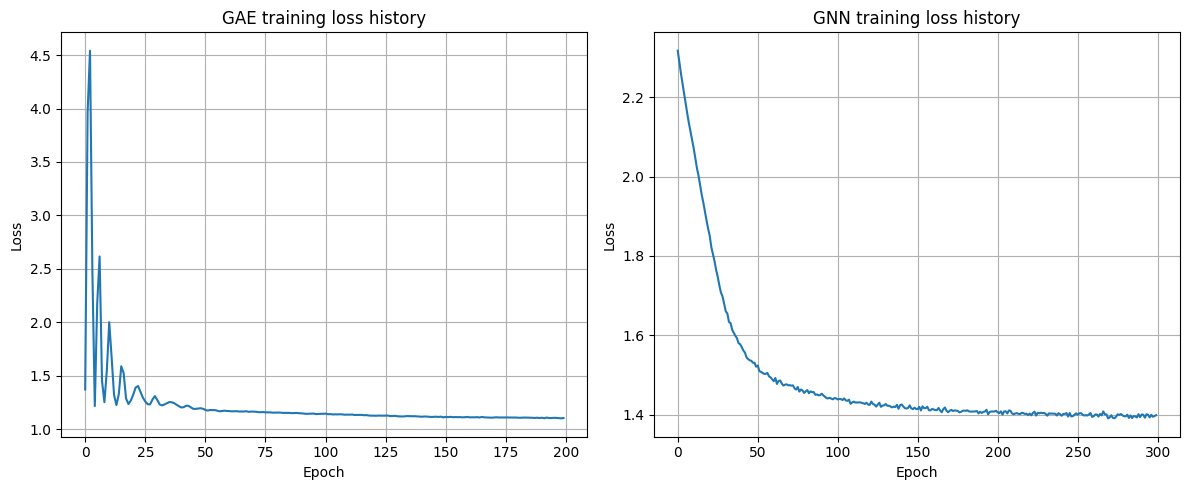

In [21]:
plt.figure(figsize=(12, 5))

# GAE training loss history
plt.subplot(1, 2, 1)
plt.plot(GAE_loss_history, label='GAE training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAE training loss history')
plt.grid(True)  # Assuming you want to always display the grid


# GNN training loss history
plt.subplot(1, 2, 2)
plt.plot(GNN_loss_history, label='GNN training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GNN training loss history')
plt.grid(True)  # Assuming you want to always display the grid


plt.tight_layout()
plt.show()

Time taken to build KNN graph: 33.35 seconds
RAM used to build KNN graph: Current=13.27MB, Peak=13.27MB
GPU memory used to build KNN graph: 0.00MB
Data(x=[25000, 784], edge_index=[2, 125000], y=[25000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784
Calculating d_hd
fMNIST GAE-residual


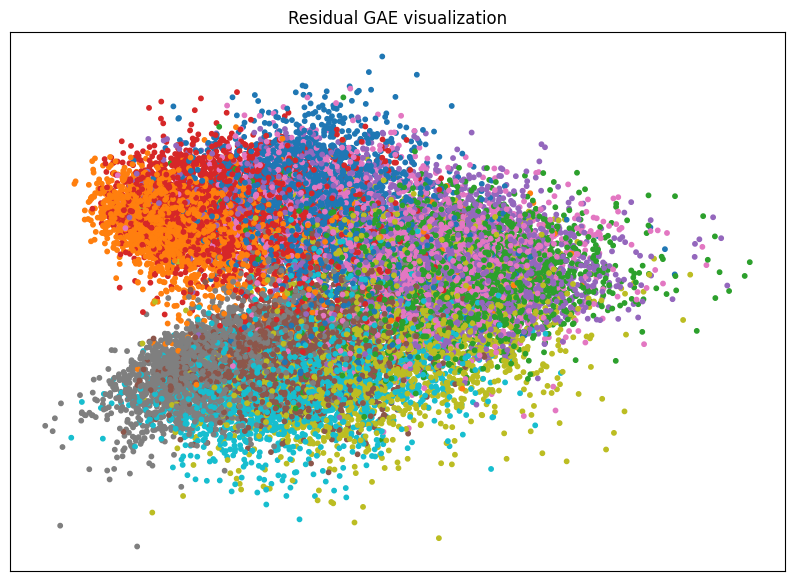

In [22]:
pure_data = get_fmnist_graph(25000)
pure_X = pure_data.x.cpu().detach().numpy()
pure_labels = pure_data.y.cpu().numpy()

GAE_variant = "residual"
dataset_name = "fMNIST"
algorithm_name = "GAE"
local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=encoded_features.cpu().detach().numpy(),
    X_hds=pure_X,
    labels=pure_labels,
    method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}-{GAE_variant}"))

visualise(encoded_features.cpu().detach().numpy(), pure_labels, 'Residual GAE visualization', size=10)

# 2. Residual GAE + tSNE

Time taken to build KNN graph: 34.48 seconds
RAM used to build KNN graph: Current=13.27MB, Peak=13.27MB
GPU memory used to build KNN graph: 0.00MB
Data(x=[25000, 784], edge_index=[2, 125000], y=[25000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Training GAE model...
Epoch: 10, Loss: 1.261451244354248
Epoch: 20, Loss: 1.161045789718628
Epoch: 30, Loss: 1.1019052267074585
Epoch: 40, Loss: 1.0686841011047363
Epoch: 50, Loss: 1.0483932495117188
Epoch: 60, Loss: 1.0312151908874512
Epoch: 70, Loss: 1.017099380493164
Epoch: 80, Loss: 1.0073822736740112
Epoch: 90, Loss: 0.9983294010162354
Epoch: 100, Loss: 0.9926539659500122
Epoch: 110, Loss: 0.9862139225006104
Epoch: 120, Loss: 0.9765071868896484
Epoch: 130, Loss: 0.9712194204330444
Epoch: 140, Loss: 0.9651221036911011
Epoch: 150, Loss: 0.9662097692489624
Epoch: 160, Loss: 0.9568049907684326
Epoch: 170, Loss: 0.9589753150939941
Epoch: 180, Loss: 0.951438307762146
Epoch: 190, Loss: 0.9474415183067322
Epoch: 200, Loss: 0.9441490173339844
GAE Training Time: 112.70 seconds
GAE Training RAM Memory usage: Current=0.10MB, Peak=13.10MB
GAE Training GPU Memory usage: 2.36MB
Epoch 0, Loss: 2.360588788986206
Epoch 10, Loss: 2.031496286392212
Epoch 20, Loss: 1.725207805633545
Epoch 30, Loss: 1.

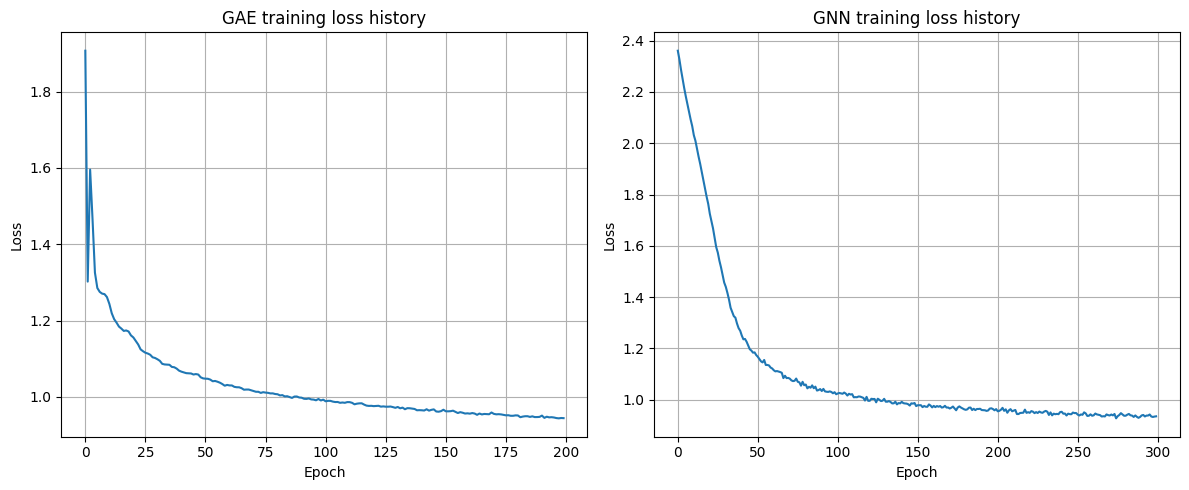

Calculating d_hd
fMNIST GAE-residual + t-SNE


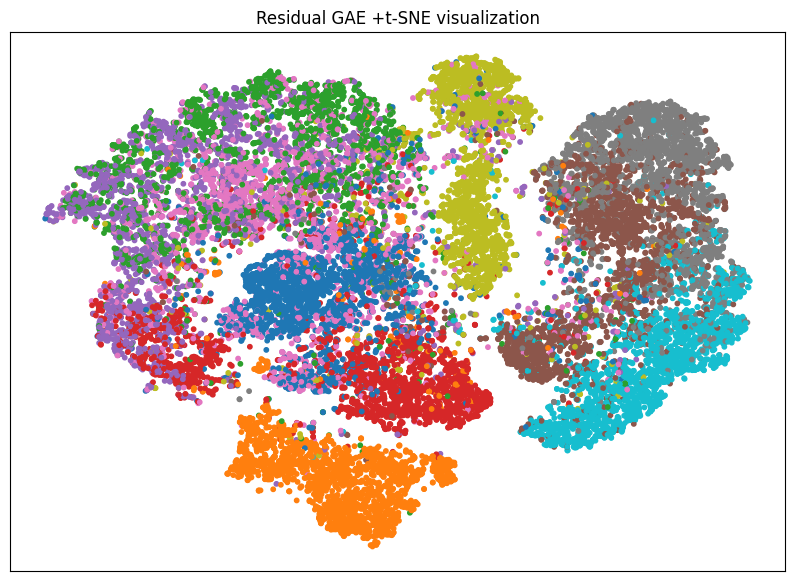

In [23]:
data = get_fmnist_graph(25000)

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
# data.train_mask = data.val_mask = data.test_mask = data.y = None  # Ensure these are not used by train_test_split_edges

data = train_test_split_edges(data)

# Parameters
out_channels_AE = 16
num_features = data.num_features
num_classes = data.num_classes
epochs_AE = 200
hidden_channels_AE = 32

# Model initialization
model = GAE(ResidualGCNEncoder(num_features, hidden_channels_AE, out_channels_AE)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

GAE_loss_history = []

# Training the GAE model with metrics measurement
print("Training GAE model...")
tracemalloc.start()
start_time = time.time()
start_gpu_memory = get_gpu_memory()

for epoch in range(1, epochs_AE + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    GAE_loss_history.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
end_gpu_memory = get_gpu_memory()

# Calculate and print metrics
time_taken = end_time - start_time
ram_used = (current - peak) / 1024 / 1024  # Convert to MB
gpu_used = end_gpu_memory - start_gpu_memory

print(f"GAE Training Time: {time_taken:.2f} seconds")
print(f"GAE Training RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
print(f"GAE Training GPU Memory usage: {gpu_used:.2f}MB")

# Update data.x with the encoded features for classification
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach()
data.x = encoded_features
hidden_channels_GNN = 16

# Initialize the GNN model for node classification
gnn_model = GNNNodeClassifier(out_channels_AE, hidden_channels_GNN, num_classes).to(device)
optimizer_gnn = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Reconstruct full edge_index from the split edges for training the GNN
full_edge_index = torch.cat([data.train_pos_edge_index, data.val_pos_edge_index, data.test_pos_edge_index], dim=-1).to(device)

GNN_loss_history = []

# Training the GNN model
for epoch in range(300):
    gnn_model.train()
    optimizer_gnn.zero_grad()
    out = gnn_model(data.x, full_edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
    loss.backward()
    optimizer_gnn.step()
    GNN_loss_history.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data.x, full_edge_index)
    preds = out.argmax(dim=1)
    labels = data.y
    mask = data.test_mask
    test_preds = preds[mask].cpu().numpy()
    test_labels = labels[mask].cpu().numpy()

    accuracy = accuracy_score(test_labels, test_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='macro')

print(f"GNN accuracy: {accuracy:.4f}, GNN precision: {precision:.4f}, GNN recall: {recall:.4f}, GNN F1 score: {f1:.4f}")

tsne = TSNE(n_components=2, random_state=0)

# Perform t-SNE transformation with metrics measurement
print("Performing t-SNE transformation...")
tracemalloc.start()
start_time = time.time()
start_gpu_memory = get_gpu_memory()

tsne_results = tsne.fit_transform(encoded_features.cpu().detach().numpy())

end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
end_gpu_memory = get_gpu_memory()

# Calculate and print metrics
time_taken = end_time - start_time
ram_used = (current - peak) / 1024 / 1024  # Convert to MB
gpu_used = end_gpu_memory - start_gpu_memory

print(f"t-SNE Transformation Time: {time_taken:.2f} seconds")
print(f"t-SNE Transformation RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
print(f"t-SNE Transformation GPU Memory usage: {gpu_used:.2f}MB")
plt.figure(figsize=(12, 5))

# GAE training loss history
plt.subplot(1, 2, 1)
plt.plot(GAE_loss_history, label='GAE training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAE training loss history')
plt.grid(True)  # Assuming you want to always display the grid


# GNN training loss history
plt.subplot(1, 2, 2)
plt.plot(GNN_loss_history, label='GNN training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GNN training loss history')
plt.grid(True)  # Assuming you want to always display the grid


plt.tight_layout()
plt.show()

pure_labels = pure_data.y.cpu().numpy()

GAE_variant = "residual + t-SNE"
dataset_name = "fMNIST"
algorithm_name = "GAE"
local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=tsne_results,
    X_hds=pure_X,
    labels=pure_labels,
    method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}-{GAE_variant}"))

visualise(tsne_results, pure_labels, 'Residual GAE +t-SNE visualization', size=10)


# 3. pure t-SNE

Performing t-SNE transformation...
t-SNE Transformation Time: 399.56 seconds
t-SNE Transformation RAM Memory usage: Current=0.26MB, Peak=157.72MB
t-SNE Transformation GPU Memory usage: 0.00MB
Calculating d_hd
fMNIST t-SNE


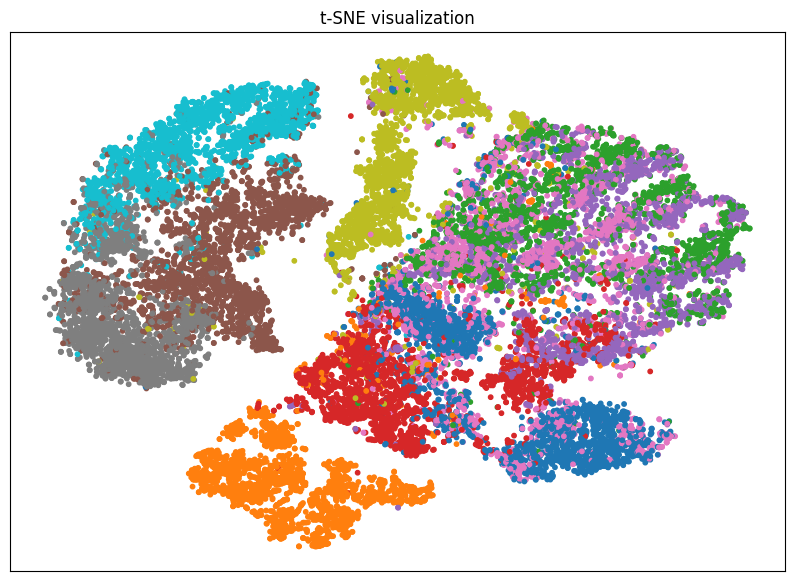

In [24]:
tsne = TSNE(n_components=2, random_state=0)
# Perform t-SNE transformation with metrics measurement
print("Performing t-SNE transformation...")
tracemalloc.start()
start_time = time.time()
start_gpu_memory = get_gpu_memory()

tsne_results = tsne.fit_transform(pure_X)

end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
end_gpu_memory = get_gpu_memory()

# Calculate and print metrics
time_taken = end_time - start_time
ram_used = (current - peak) / 1024 / 1024  # Convert to MB
gpu_used = end_gpu_memory - start_gpu_memory

print(f"t-SNE Transformation Time: {time_taken:.2f} seconds")
print(f"t-SNE Transformation RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
print(f"t-SNE Transformation GPU Memory usage: {gpu_used:.2f}MB")


GAE_variant = "t-SNE"
dataset_name = "fMNIST"
algorithm_name = ""
local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=tsne_results,
    X_hds=pure_X,
    labels=pure_labels,
    method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}{GAE_variant}"))

visualise(tsne_results, pure_labels, 't-SNE visualization', size=10)


Finished.


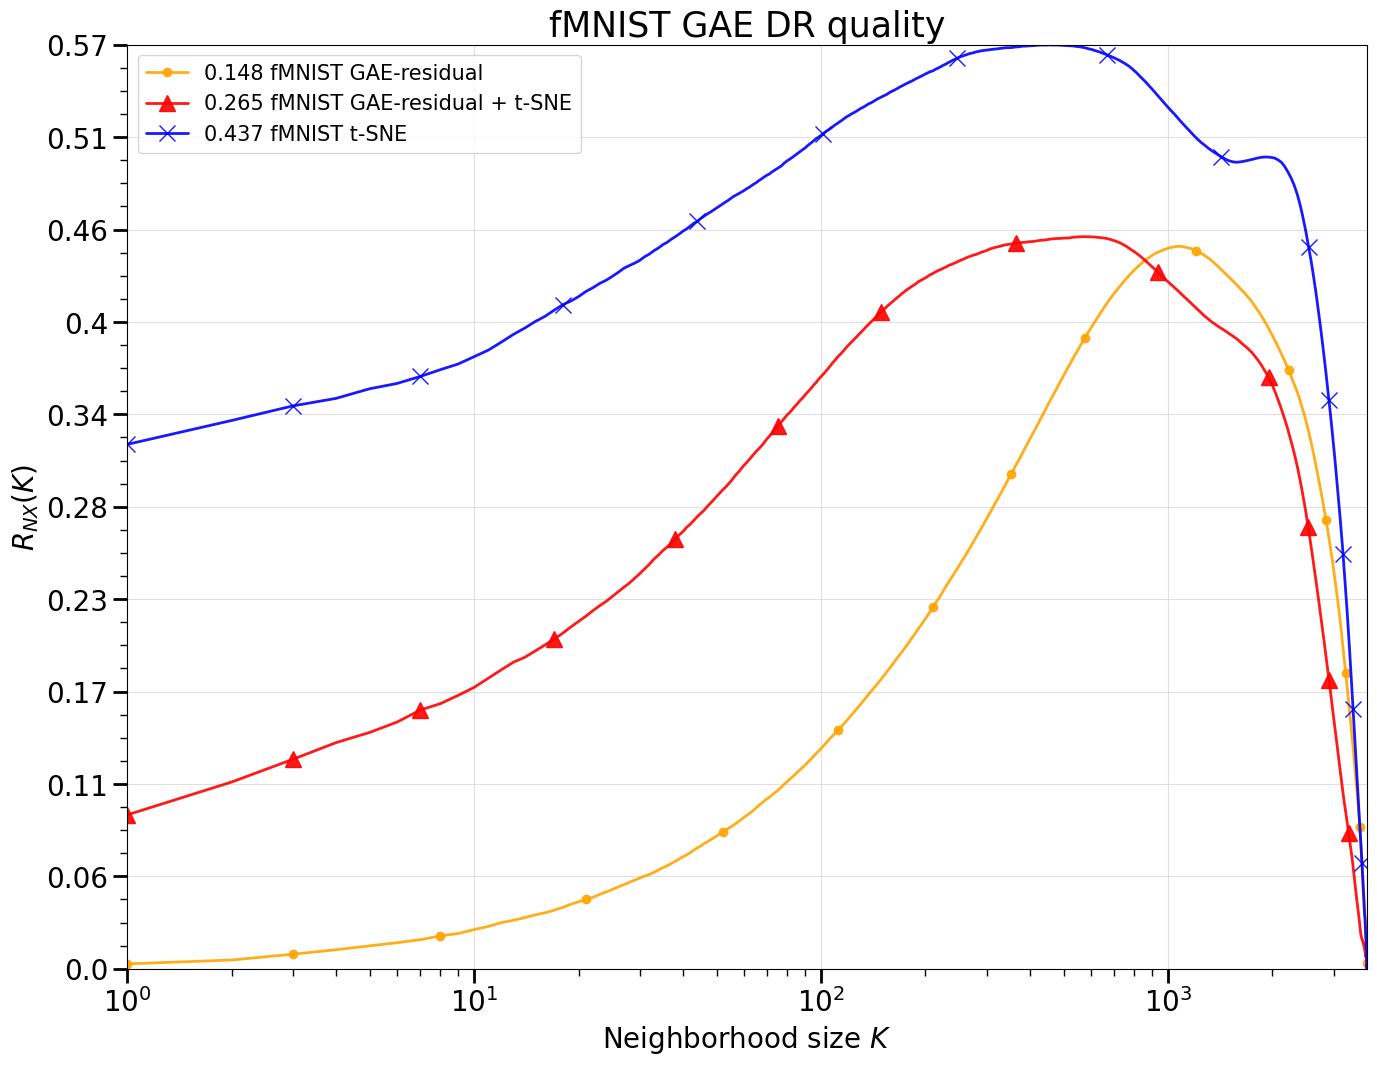

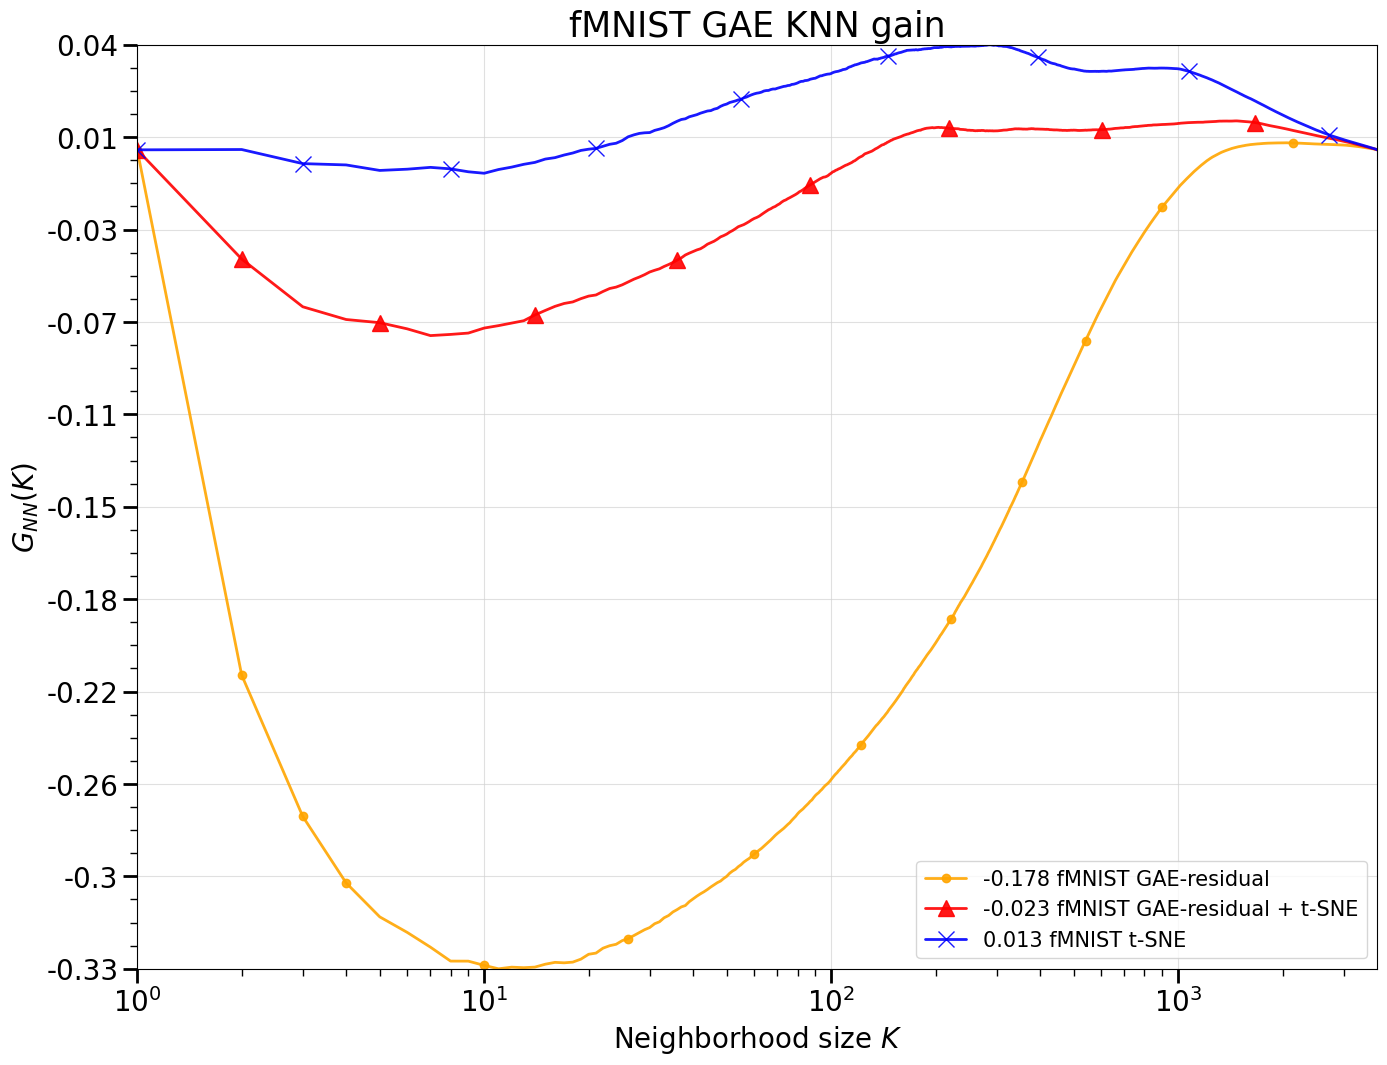

In [25]:
local_metrics.visualize(f"fMNIST GAE")